In [146]:
import pandas as pd
import numpy as np

In [147]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'C:\Users\91783\Desktop\Bhiwadi_hourly\Bhiwadi2022_Uni_LSTM.csv',
                                parse_dates=['DateTime'],
                                index_col=['DateTime'])

df.head()

,PM2.5
DateTime,
2021-01-01 00:00:00,389.82
2021-01-01 01:00:00,396.16
2021-01-01 02:00:00,332.44
2021-01-01 03:00:00,274.54
2021-01-01 04:00:00,294.05


In [148]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12833 entries, 2021-01-01 00:00:00 to 2022-06-19 16:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   12833 non-null  float64
dtypes: float64(1)
memory usage: 200.5 KB


<AxesSubplot:>

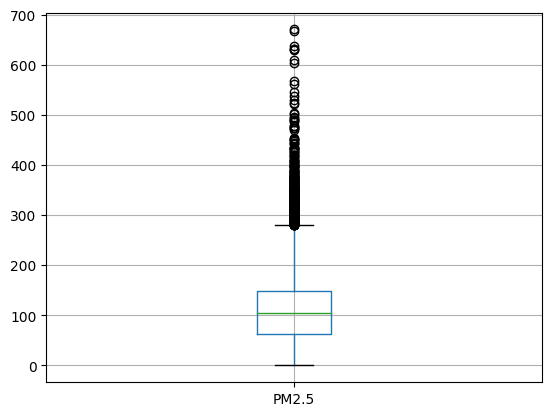

In [149]:
 #Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [150]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [151]:
scaled_dataset[:2,:]

array([[0.58099809],
       [0.59044837]])

In [152]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [153]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (12829, 1)
X (12829, 4, 1)


In [154]:
#Splitting the dataset 12829*0.2=2565 => - 10264
#Splitting the dataset 12829*0.3=8981 => -8981
n_train = 2565
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (10264, 4, 1)
X_test (2565, 4, 1)
Y_train (10264, 1)
Y_test (2565, 1)


In [155]:
#Importing LSTM model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
import tensorflow as tf
model = Sequential()

#units means number of neurons
model.add(LSTM(units = 100, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

 
#opt1 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD")

opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt)

In [156]:
history = model.fit(X_train, Y_train, epochs=50,
                    batch_size=32, validation_data=(X_test, Y_test),
                    verbose=2, shuffle=False)

Epoch 1/50
321/321 - 10s - loss: 0.1444 - val_loss: 0.0177 - 10s/epoch - 32ms/step
Epoch 2/50
321/321 - 6s - loss: 0.0375 - val_loss: 0.0173 - 6s/epoch - 18ms/step
Epoch 3/50
321/321 - 6s - loss: 0.0604 - val_loss: 0.0134 - 6s/epoch - 18ms/step
Epoch 4/50
321/321 - 6s - loss: 0.0801 - val_loss: 0.0306 - 6s/epoch - 18ms/step
Epoch 5/50
321/321 - 6s - loss: 0.0608 - val_loss: 0.0143 - 6s/epoch - 18ms/step
Epoch 6/50
321/321 - 6s - loss: 0.0599 - val_loss: 0.0114 - 6s/epoch - 18ms/step
Epoch 7/50
321/321 - 6s - loss: 0.0689 - val_loss: 0.0133 - 6s/epoch - 18ms/step
Epoch 8/50
321/321 - 6s - loss: 0.0569 - val_loss: 0.0163 - 6s/epoch - 18ms/step
Epoch 9/50
321/321 - 6s - loss: 0.0580 - val_loss: 0.0340 - 6s/epoch - 18ms/step
Epoch 10/50
321/321 - 6s - loss: 0.0652 - val_loss: 0.0549 - 6s/epoch - 18ms/step
Epoch 11/50
321/321 - 6s - loss: 0.0644 - val_loss: 0.0199 - 6s/epoch - 18ms/step
Epoch 12/50
321/321 - 6s - loss: 0.0627 - val_loss: 0.0246 - 6s/epoch - 18ms/step
Epoch 13/50
321/321 - 6

In [157]:
#Taking predictions
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

print(mse)
rmse = np.sqrt(mse)
print(rmse)

81/81 [==============================] - 1s 4ms/step
0.018340855255277372
0.13542841376637832


In [158]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(Y_test, Y_pred)
print('MAPE', mape)

MAPE 113.08025866337898


In [159]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, Y_pred)
r2

-0.9085972926102661

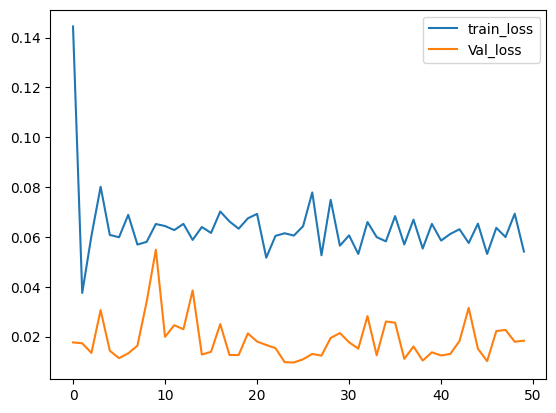

In [160]:
# plot history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.legend()
plt.show()

In [161]:
me = np.mean(Y_pred - Y_test)
print('ME')
print(me)
mae = np.mean(np.abs(Y_pred - Y_test))    # MAE
print('MAE')
print(mae)
mpe = np.mean((Y_pred - Y_test)/Y_test)   # MPE
print('MPE')
print(mpe)
rmse = np.mean((Y_pred - Y_test)**2)**.5  # RMSE
print('RMSE')
print(rmse)
 

ME
0.09344118923235542
MAE
0.11766436486214321
MPE
1.0733478678387491
RMSE
0.13542841376637832
